In [1]:
from pathlib import Path

from typing import Any, Literal
from collections.abc import Callable, Sequence
from torch.types import Device

from collections import deque

from numpy.typing import NDArray

from pandas import DataFrame

import pandas as pd

from gymnasium.vector import AsyncVectorEnv

import numpy as np

import torch

from gymnasium import Env, make_vec

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable, get_cmap

sns.set_style('whitegrid')

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from cpscheduler import SingleMachineSetup, WeightedTardiness, TotalTardiness
from cpscheduler.environment.metrics import ReferenceScheduleMetrics
from cpscheduler.gym import SchedulingEnvGym, PermutationActionWrapper, ArrayObservationWrapper

import cpscheduler.rl as rl
from cpscheduler.rl.evaluation import ccdf, confidence_interval

INSTANCE_PATH = Path("data/customers/wt40_50_0.5.pkl")
DATASET_PATH = Path("data/customers/wt40_50_0.5_dataset.pkl")

features = ["processing_time", "due_date", "customer"]

device = rl.utils.get_device()

paths = sorted(Path("logs/ablations/reinforce_frac").glob("*"))

def load_tensorboard_data(logdir: str | Path) -> pd.DataFrame:
    acc = EventAccumulator(str(logdir))
    acc.Reload()

    tags = acc.Tags()['scalars']

    df = pd.DataFrame()

    for tag in tags:
        events = acc.Scalars(tag)

        df_tag = pd.DataFrame(events)

        df_tag.drop(columns=['wall_time'], inplace=True)
        df_tag.rename(columns={'value': tag}, inplace=True)
        df_tag.set_index('step', inplace=True)

        df = df.join(df_tag, how='outer')

    return df

In [ ]:
df_lst: list[DataFrame] = []
fracs = [0.1, 0.25, 0.33, 0.5, 0.8]

for i, path in enumerate(paths):
    df = load_tensorboard_data(path)
    df = df.assign(data_fraction=fracs[i // 10])
    df_lst.append(df)

results = pd.concat(df_lst).reset_index(drop=False)
steps = np.sort(results["step"].drop_duplicates().to_numpy())

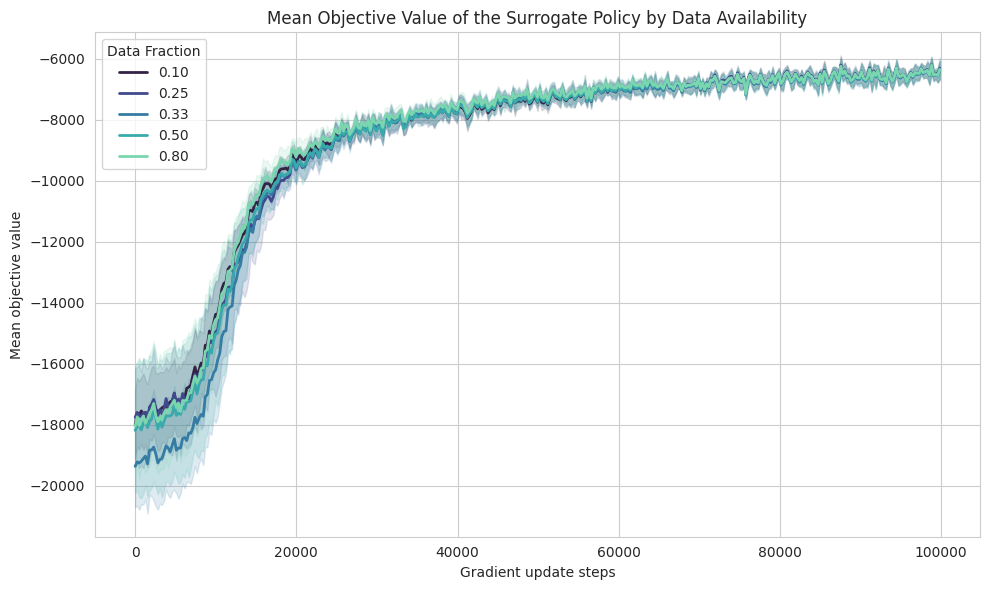

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette("mako", n_colors=5)


for i, (frac, df) in enumerate(results.groupby("data_fraction")):
    array = np.stack(df.groupby("step")['start/rewards/mean'].apply(np.array).to_list())
    _, lower, upper = confidence_interval(
        array,
        n_bootstrap=1000,
        confidence=0.95
    )

    ax.plot(steps, np.mean(array, axis=-1), label=f"{frac:.2f}", linewidth=2, color=colors[i])
    ax.fill_between(
        steps,
        lower,
        upper,
        alpha=0.15,
        color=colors[i],
    )

ax.set_xlabel("Gradient update steps")
ax.set_ylabel("Mean objective value")
ax.set_title("Mean Objective Value of the Surrogate Policy by Data Availability")
ax.legend(title="Data Fraction")

plt.savefig("notebooks/figures/reinforce/mean_objective.pdf", dpi=300)

plt.tight_layout()
plt.show()

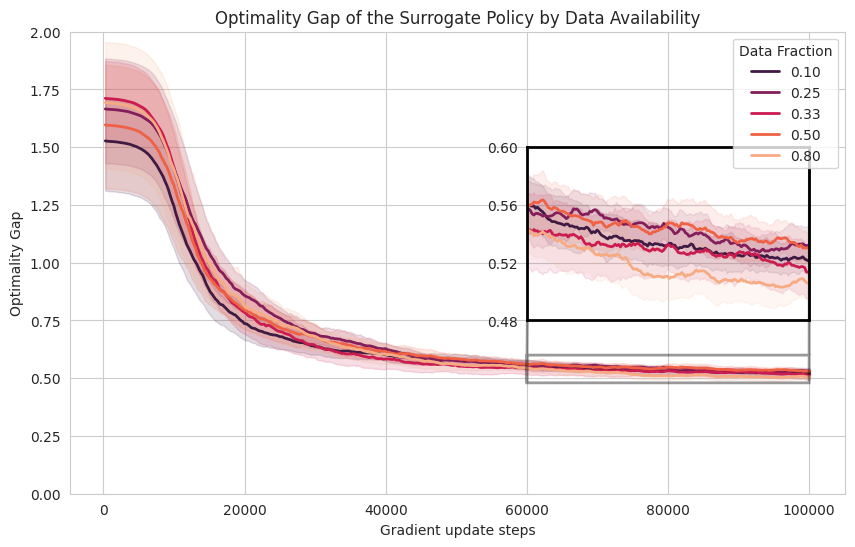

In [228]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = sns.color_palette("rocket", n_colors=5)


axins = ax.inset_axes([0.59, 0.375, 0.364, 0.375])  # [x, y, width, height]
ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.4, linewidth=2)

axins.set_facecolor((0, 0, 0, 0))

# Set the color of the spines to black and line width to 2
axins.spines['top'].set_linewidth(2)
axins.spines['right'].set_linewidth(2)
axins.spines['bottom'].set_linewidth(2)
axins.spines['left'].set_linewidth(2)

axins.spines['top'].set_color('black')
axins.spines['right'].set_color('black')
axins.spines['bottom'].set_color('black')
axins.spines['left'].set_color('black')

for i, (frac, df) in enumerate(results.groupby("data_fraction")):
    array = np.stack(df.groupby("step")['val/optimal_gap'].apply(np.array).to_list())

    _, lower, upper = confidence_interval(
        array,
        n_bootstrap=1000,
        confidence=0.95
    )

    ax.plot(steps, np.mean(array, axis=-1), label=f"{frac:.2f}", linewidth=2, color=colors[i])
    ax.fill_between(
        steps,
        lower,
        upper,
        alpha=0.15,
        color=colors[i],
    )

    axins.fill_between(
        steps,
        lower,
        upper,
        alpha=0.1,
        color=colors[i],
    )
    axins.plot(steps, np.mean(array, axis=-1), label=f"{frac:.2f}", linewidth=2, color=colors[i])


ax.set_xlabel("Gradient update steps")
ax.set_ylabel("Optimality Gap")
ax.set_title("Optimality Gap of the Surrogate Policy by Data Availability")
ax.legend(title="Data Fraction")

ax.set_ylim(0., 2.)

axins.set_xlim(60000, 100000)
axins.set_ylim(0.48, 0.6)
axins.set_xticks([])
# axins.set_yticks([])
# axins.set_title("Zoomed In View")

axins.set_yticks([0.48, 0.52, 0.56, 0.6])


plt.savefig("notebooks/figures/reinforce/optimal_gap.pdf", dpi=300)

# plt.tight_layout()
plt.show()

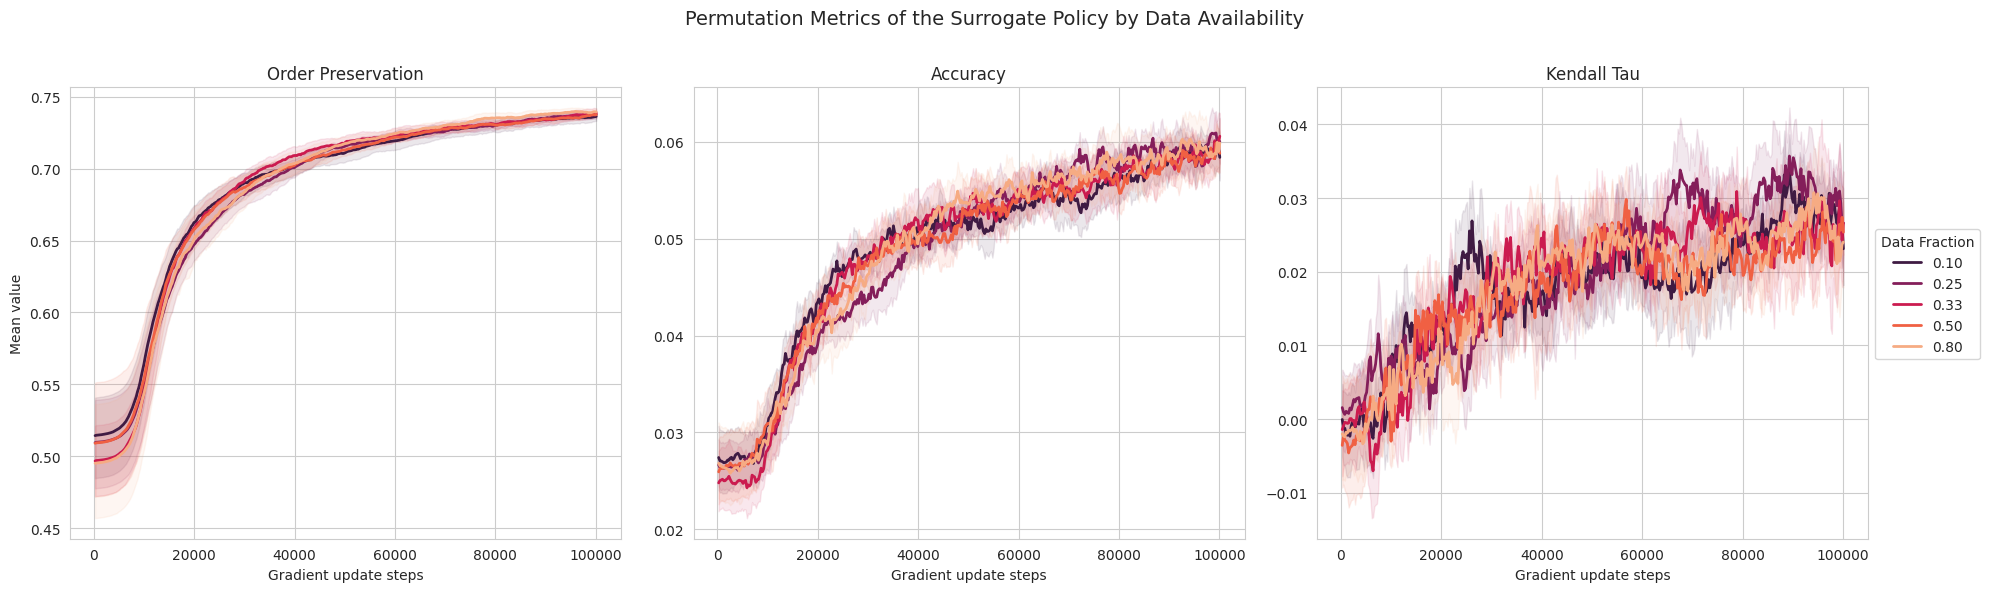

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))

colors = sns.color_palette("rocket", n_colors=5)

for i, (frac, df) in enumerate(results.groupby("data_fraction")):
    for j, metric in enumerate([
        "val/order_preservation/mean",
        "val/accuracy/mean",
        "val/kendall_tau/mean"
    ]):
        ax: Axes = axs[j]
        array = np.stack(df.groupby("step")[metric].apply(np.array).to_list())

        _, lower, upper = confidence_interval(
            array,
            n_bootstrap=1000,
            confidence=0.95
        )

        ax.plot(steps, np.mean(array, axis=-1), label=f"{frac:.2f}", linewidth=2, color=colors[i])
        ax.fill_between(
            steps,
            lower,
            upper,
            alpha=0.1,
            color=colors[i],
        )

axs[0].set_ylabel("Mean value")
for ax in axs:
    ax.set_xlabel("Gradient update steps")

# Put legend outside the plot
axs[0].set_title("Order Preservation")
axs[1].set_title("Accuracy")
axs[2].set_title("Kendall Tau")

axs[-1].legend(title="Data Fraction", loc='upper left', bbox_to_anchor=(1, 0.7))
plt.tight_layout()

plt.subplots_adjust(top=0.85)
plt.suptitle("Permutation Metrics of the Surrogate Policy by Data Availability", fontsize=14)

plt.savefig("notebooks/figures/reinforce/permutation_metrics.pdf", dpi=300)
plt.show()


In [2]:
list_instances: list[DataFrame]
instance_info: DataFrame
customer_information: DataFrame

list_instances, instance_info, customer_information = pd.read_pickle(INSTANCE_PATH)
train_dataset: list[DataFrame] = pd.read_pickle(DATASET_PATH)

behavior_performance = instance_info["behavior"].to_numpy()
optimal_performance = instance_info["optimal"].to_numpy()
thresholds = np.linspace(0, 1, num=100)

optimal_action = np.load("data/customers/optimal_actions.npy")

paths = list(Path("logs/pl_reinforce").rglob("*.pkl"))
n_models = len(paths)

def div(numerator: NDArray[np.float32], denominator: NDArray[np.float32]) -> NDArray[np.float32]:
    with np.errstate(divide='ignore', invalid='ignore'):
        result = numerator / denominator
        zero_over_zero = (numerator == 0) & (denominator == 0)
        k_over_zero = (denominator == 0) & (numerator != 0)

        result[zero_over_zero] = 1.0
        result[k_over_zero] = np.sign(numerator[k_over_zero])

    return result

def normalized_performance(performance: NDArray[np.float32], ref: NDArray[np.float32]) -> NDArray[np.float32]:
    """
    Normalize performance to the range [0, 1], where a policy as performatic as the reference has a optimal performance of 1,
    and a policy as performatic as the reference policy has a normalized performance of 0.
    """
    rel_perf   = ref[(slice(None),) + (None,) * (performance.ndim - 1)] - performance
    ref_regret = (ref - optimal_performance)[(slice(None),) + (None,) * (performance.ndim - 1)]

    return div(rel_perf, ref_regret)


In [6]:
ref = ReferenceScheduleMetrics("BPolicy start")

def make_env(instance: DataFrame) -> Callable[[], Env[Any, Any]]:
    def inner() -> Env[Any, Any]:
        env = SchedulingEnvGym(
            machine_setup=SingleMachineSetup(),
            objective=WeightedTardiness(),
            instance_config={"instance": instance},
            metrics={
                "total_tardiness": TotalTardiness(),
                "order_preservation": ref.order_preservation,
                "accuracy": ref.hamming_accuracy,
                "kendall_tau": ref.kendall_tau,
            }
        )
        env = ArrayObservationWrapper(env, features)
        env = PermutationActionWrapper(env)
        return env

    return inner

val_envs = AsyncVectorEnv(
    [
        make_env(instance)
        for i, instance in enumerate(list_instances)
    ]
)

dataset = torch.cat(
    [
        torch.tensor(df[features].values, dtype=torch.float32).unsqueeze(0)
        for df in train_dataset
    ]
).to(device)

val_obs = torch.cat(
    [
        torch.tensor(df[features].values, dtype=torch.float32).unsqueeze(0)
        for df in list_instances
    ]
).to(device)

In [18]:
mesh = torch.tensor(
    [
        [[[x, y, customer] for y in range(1, 3001)] for x in range(1, 101)] for customer in range(50)
    ],
    dtype=torch.float32,
    device=device
)

mean_score = torch.zeros(
    mesh.shape[:-1],
    dtype=torch.float32,
    device=device
)

total_tardiness = torch.zeros((len(paths), val_obs.shape[0]), dtype=torch.float32)

for i, path in enumerate(paths):
    policy: rl.policies.PlackettLucePolicy = torch.load(path, map_location=device, weights_only=False)
    rl.utils.turn_off_grad(policy)
    
    val_envs.reset()
    actions = policy.greedy(val_obs)

    *_, info = val_envs.step(actions.cpu())

    total_tardiness[i] = torch.from_numpy(info["total_tardiness"])
    mean_score += policy.get_score(mesh)

mean_score /= n_models

torch.cuda.empty_cache()
scores = mean_score.cpu().numpy()

In [25]:
torch.mean(torch.mean(total_tardiness, dim=1) / 9233.944000000034 - 1)

tensor(0.1230)

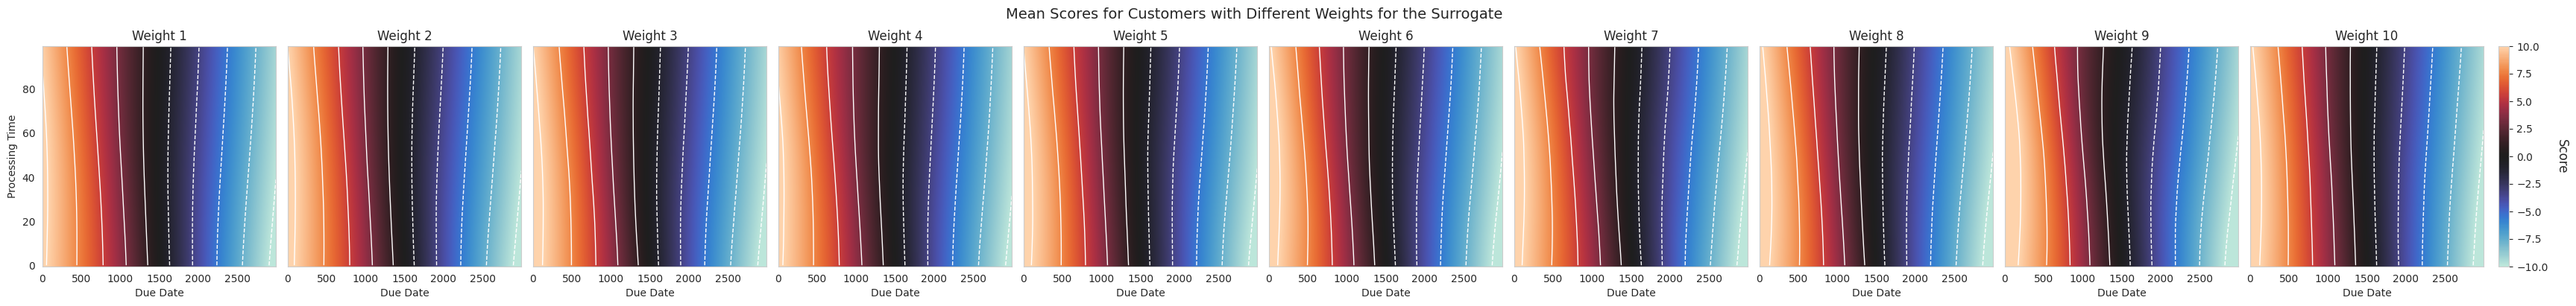

In [5]:
plt.figure(figsize=(50, 4))

plt.subplots_adjust(wspace=0.05, hspace=0.1, top=0.85)

min_value = -10
max_value =  10

for weight in range(1, 11):
    ax = plt.subplot(1, 10, weight)

    customers = customer_information.index[customer_information['weight_original'] == weight].to_numpy()

    grid = scores[customers, :, :].mean(axis=0)
    ax.imshow(grid, cmap='icefire', aspect='auto', vmin=min_value, vmax=max_value)
    ax.contour(grid, colors='white', linewidths=1, levels=np.linspace(min_value, max_value, 10))

    ax.set_xlabel('Due Date')
    ax.set_title(f'Weight {weight}')
    ax.grid(False)

    ax.invert_yaxis()

    if weight == 1:
        ax.set_ylabel('Processing Time')
    else:
        ax.set_yticks([])

cbar = plt.colorbar(ax.images[0], ax=plt.gcf().get_axes(), pad=0.005)

cbar.set_label('Score', rotation=270, fontsize=12, labelpad=20)

plt.suptitle('Mean Scores for Customers with Different Weights for the Surrogate', fontsize=14, x=0.45)

plt.savefig("notebooks/figures/reinforce/scores.pdf", dpi=300)

plt.show()

In [ ]:
n_repeats = 100

performance = np.zeros((len(list_instances), n_models), dtype=np.float32)
stochastic_performance = np.zeros((len(list_instances), n_models, n_repeats), dtype=np.float32)

for i, path in enumerate(paths):
    policy: rl.policies.PlackettLucePolicy = torch.load(path, map_location=device, weights_only=False)
    rl.utils.turn_off_grad(policy)

    actions = policy.greedy(val_obs).cpu()

    val_envs.reset()
    _, returns, *_, info = val_envs.step(actions)

    performance[:, i] = - returns

    for j in range(n_repeats):
        val_envs.reset()

        actions, _ = policy.sample_pstar(val_obs, target_prob=0.9, n_iter=10)

        _, returns, *_, info = val_envs.step(actions.cpu())

        stochastic_performance[:, i, j] = - returns


/tmp/ipykernel_486681/3524007827.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


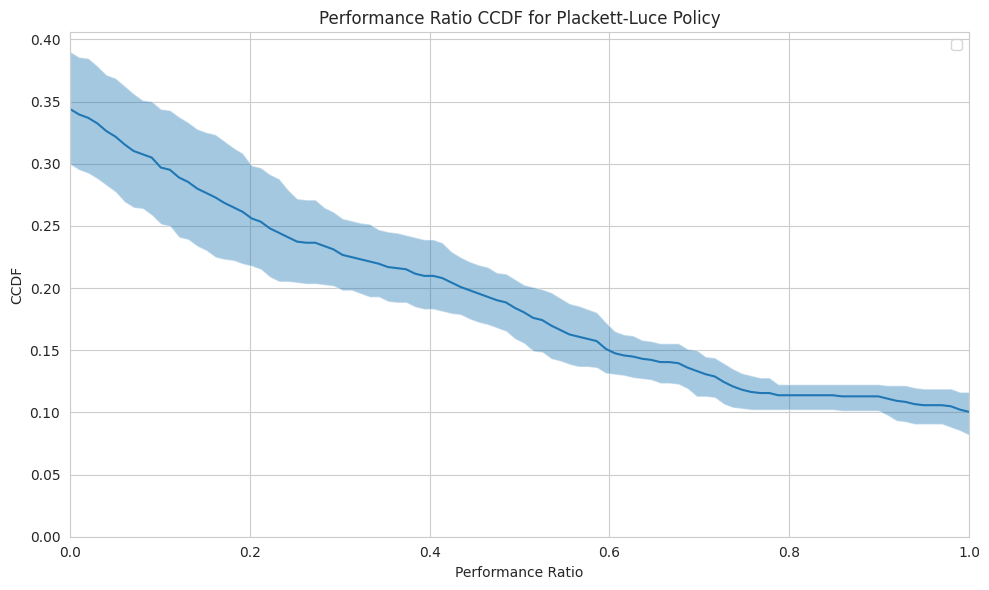

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = normalized_performance(performance, behavior_performance)

_, lower, upper = confidence_interval(
    metrics,
    n_bootstrap=1000,
    confidence=0.95,
    statistic="ccdf",
    axis=-1,
    thresholds=thresholds
)

ax.plot(thresholds, np.mean(ccdf(metrics, thresholds=thresholds), axis=0))
ax.fill_between(
    thresholds,
    np.mean(lower, axis=0),
    np.mean(upper, axis=0),
    alpha=0.4
)

ax.set_ylim(0)
ax.set_xlim(0, 1)

ax.set_xlabel("Performance Ratio")
ax.set_ylabel("CCDF")
ax.set_title("Performance Ratio CCDF for Plackett-Luce Policy")
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
def k_ball(
    n: int,
    k: int,
) -> list[list[int]]:
    initial = list(range(n))

    queue = deque([(initial, 0)])
    visited: set[tuple[int, ...]] = set([tuple(initial)])
    k_ball = [initial]

    while queue:
        current, depth = queue.popleft()

        if depth >= k:
            continue

        for i in range(n-1):
            if current[i] > current[i+1]:
                continue

            new_perm = current.copy()

            new_perm[i], new_perm[i+1] = new_perm[i+1], new_perm[i]

            if tuple(new_perm) not in visited:
                queue.append((new_perm, depth + 1))
                visited.add(tuple(new_perm))
                k_ball.append(new_perm)

    return k_ball


def neighbourhood(
    policy: rl.policies.PlackettLucePolicy,
    envs: AsyncVectorEnv,
    obs: torch.Tensor,
    reference_action: torch.Tensor,
    k: int = 2,
) -> tuple[torch.Tensor, torch.Tensor]:
    *batch, n = reference_action.shape

    indices = torch.tensor(
        k_ball(n, k),
        device=reference_action.device
    ).unsqueeze(1).expand(-1, *batch, n)

    reference_action = reference_action.unsqueeze(0).expand(len(indices), *batch, n)

    n_perms = indices.shape[0]
    permutations = torch.gather(reference_action, dim=-1, index=indices)

    log_probs = policy.log_prob(obs.unsqueeze(0).expand(n_perms, *obs.shape), permutations)

    returns = torch.zeros_like(log_probs)

    for i, perms in enumerate(permutations):
        envs.reset()
        _, r, *_, info = envs.step(perms.cpu())

        returns[i] = - torch.tensor(r)
    
    return returns, log_probs
        

In [7]:
modal_perm = policy.greedy(val_obs).cpu()

returns, log_probs = neighbourhood(
    policy,
    val_envs,
    val_obs,
    modal_perm.to(device),
    k=2
)

optimal_returns, optimal_log_probs = neighbourhood(
    policy,
    val_envs,
    val_obs,
    torch.tensor(optimal_action, device=device),
    k=2
)

In [8]:
probs = log_probs.to(torch.float64).exp()
probs = probs / probs.sum(dim=0, keepdim=True)

optimal_probs = optimal_log_probs.to(torch.float64).exp()
optimal_probs = optimal_probs / optimal_probs.sum(dim=0, keepdim=True)

stability = returns[0] - (probs * returns).sum(dim=0) 
optimal_stability = optimal_returns[0] - (optimal_probs * optimal_returns).sum(dim=0)

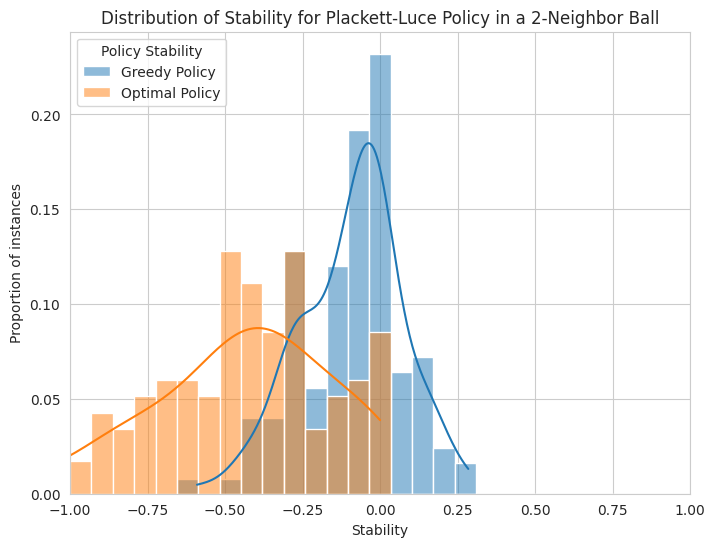

In [212]:
# Show the distributions of stability
fig, ax = plt.subplots(figsize=(8, 6))

x_max = 1
x_min = -1

bins = np.linspace(x_min, x_max, 30)

sns.histplot(
    stability.cpu().numpy(),
    bins=bins,
    kde=True,
    label="Greedy Policy",
    stat="probability",
    ax=ax
)

sns.histplot(
    optimal_stability.cpu().numpy(),
    bins=bins,
    kde=True,
    label="Optimal Policy",
    stat="probability",
    ax=ax
)
ax.set_xlabel("Stability")
ax.set_ylabel("Proportion of instances")
ax.set_title("Distribution of Stability for Plackett-Luce Policy in a 2-Neighbor Ball")

ax.legend(title="Policy Stability", loc='upper left')

ax.set_xlim(x_min, x_max)

# plt.tight_layout()

plt.savefig("notebooks/figures/reinforce/stability.pdf", dpi=300)
plt.show()

In [149]:
metrics = normalized_performance(
    returns.cpu().numpy().T,
    behavior_performance
).flatten()

optimal_metrics = normalized_performance(
    optimal_returns.cpu().numpy().T,
    behavior_performance
).flatten()

n_instances = len(metrics)

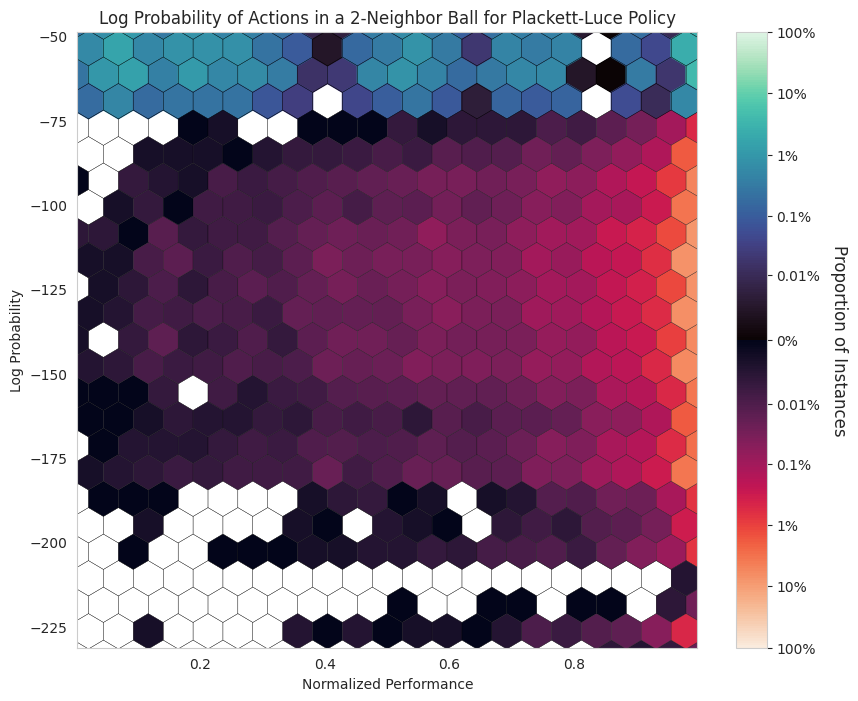

In [206]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))

rocket = plt.get_cmap("rocket_r")  # reversed
mako = plt.get_cmap("mako")

colors_combined = np.vstack([
    rocket(np.linspace(0, 1, 128)),
    mako(np.linspace(0, 1, 128))
])

combined_cmap = mcolors.LinearSegmentedColormap.from_list("rocket_mako", colors_combined)

# Normalize with midpoint at 0
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-np.log10(1 + n_instances), vmax=+np.log10(1 + n_instances))

sm = ScalarMappable(cmap=combined_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Proportion of Instances", rotation=270, fontsize=12, labelpad=20)

vmax = int(np.log10(n_instances))

proportions = [0, 0.0001, 0.001, 0.01, 0.1, 1.]
n_props = len(proportions)

cbar.set_ticks(
    ticks=[np.sign(i) * np.log10(1 + proportions[abs(i)] * n_instances) for i in range(-n_props+1, n_props)],
    labels=["100%", "10%", "1%", "0.1%", "0.01%", "0%", "0.01%", "0.1%", "1%", "10%", "100%"]
)

x_min = -0.1
x_max = 1.1
y_min = -250
y_max = -30


grid = (x_min, x_max, y_min, y_max)
scale = 25


ax.hexbin(
    x=metrics[(metrics <= 1) & (metrics >= 0)],
    y=log_probs.cpu().numpy().flatten()[(metrics <= 1) & (metrics >= 0)],
    gridsize=scale,
    # norm=mcolors.LogNorm(vmin=1, vmax=n_instances),
    cmap='mako',
    mincnt=0,
    bins='log',
    extent=grid,
    vmax=n_instances,
)


ax.hexbin(
    x=optimal_metrics[(optimal_metrics <= 1) & (optimal_metrics >= 0)],
    y=optimal_log_probs.cpu().numpy().flatten()[(optimal_metrics <= 1) & (optimal_metrics >= 0)],
    gridsize=scale,
    # norm=mcolors.LogNorm(vmin=1, vmax=n_instances),
    cmap="rocket",
    mincnt=0,
    bins='log',
    extent=grid,
    edgecolors='black',
    linewidths=0.2,
    vmax=n_instances,
)

# Add the hexagons at the background
ax.set_xlabel("Normalized Performance")
ax.set_ylabel("Log Probability")
ax.set_title("Log Probability of Actions in a 2-Neighbor Ball for Plackett-Luce Policy")

alpha = 0.83

ax.set_xlim(
    x_min + (1 - alpha) * (x_max - x_min) / 2,
    x_max - (1 - alpha) * (x_max - x_min) / 2
)

ax.set_ylim(
    y_min + (1 - alpha) * (y_max - y_min) / 2,
    y_max - (1 - alpha) * (y_max - y_min) / 2
)

ax.grid(False)

# plt.tight_layout()
plt.savefig("notebooks/figures/reinforce/log_probabilities.pdf", dpi=300)

plt.show()
